In [1]:
from casacore.tables import table
import numpy as np

In [2]:
dataset= ## Set a path to aartfaac measurement  set

In [3]:
t = table(dataset)
nantenna = 1008
nsteps = nantenna * (nantenna +1) // 2
visibilities = t.getcol('DATA')[:nsteps, :, :]

positions = table(dataset + "::ANTENNA").getcol('POSITION')
frequencies = table(dataset + "::SPECTRAL_WINDOW").getcol('CHAN_FREQ')

flags = t.getcol('FLAG')[:nsteps, :, :]
visibilities[flags==True] = 0
visibilitiesI = visibilities[:, :, 0] + visibilities[:, :, 3]
visibilitiesI = np.nanmean(visibilitiesI, axis=1)


Successful readonly open of default-locked table /home/mancini/opt/aartfaac_pipeline/A21-sb206calibrated.ms: 23 columns, 2034144 rows
Successful readonly open of default-locked table /home/mancini/opt/aartfaac_pipeline/A21-sb206calibrated.ms::ANTENNA: 8 columns, 1008 rows
Successful readonly open of default-locked table /home/mancini/opt/aartfaac_pipeline/A21-sb206calibrated.ms::SPECTRAL_WINDOW: 14 columns, 1 rows


In [4]:
import matplotlib.pyplot as plt

In [5]:
center = positions.mean(axis=0)

In [6]:
def nearfield_imager(visibilities, baseline_indices, freqs, npix_p, npix_q, station_pqr, radius=1.5,
                     max_memory_mb=1000):
    """
    Nearfield imager l and m based

    Args:
        visibilities: Numpy array with visibilities, shape [num_visibilities x num_frequencies]
        baseline_indices: List with tuples of antenna numbers in visibilities, shape [2 x num_visibilities]
        freqs: List of frequencies
        npix_p: Number of pixels in p-direction
        npix_q: Number of pixels in q-direction
        extent: Extent (in m) that the image should span
        station_pqr: PQR coordinates of stations
        height: Height of image in metre
        max_memory_mb: Maximum amount of memory to use for the biggest array. Higher may improve performance.

    Returns:
        np.array(complex): Complex valued array of shape [npix_p, npix_q]
    """
    u = np.linspace(-1, 1, npix_p)
    v = np.linspace(-1, 1, npix_p)
    
    us,vs = np.meshgrid(u,v)
    ws = np.sqrt(1- us**2 - vs**2)
    posx, posy = radius * us, radius * vs 
    posz = radius * ws
    posxyz = np.transpose(np.array([posx, posy, posz]), [1, 2, 0])
    diff_vectors = (station_pqr[:, None, None, :] - posxyz[None, :, :, :])
    distances = np.linalg.norm(diff_vectors, axis=3)

    vis_chunksize = max_memory_mb * 1024 * 1024 // (8 * npix_p * npix_q)

    bl_diff = np.zeros((vis_chunksize, npix_q, npix_p), dtype=np.float64)
    img = np.zeros((npix_q, npix_p), dtype=np.complex128)
    for vis_chunkstart in range(0, len(baseline_indices), vis_chunksize):
        vis_chunkend = min(vis_chunkstart + vis_chunksize, baseline_indices.shape[0])
        # For the last chunk, bl_diff_chunk is a bit smaller than bl_diff
        bl_diff_chunk = bl_diff[:vis_chunkend - vis_chunkstart, :]
        np.add(distances[baseline_indices[vis_chunkstart:vis_chunkend, 0]],
               -distances[baseline_indices[vis_chunkstart:vis_chunkend, 1]], out=bl_diff_chunk)

        j2pi = 1j * 2 * np.pi
        for ifreq, freq in enumerate(freqs):
            v = visibilities[vis_chunkstart:vis_chunkend, ifreq][:, None, None]
            lamb = SPEED_OF_LIGHT / freq

            # v[:,np.newaxis,np.newaxis]*np.exp(-2j*np.pi*freq/c*groundbase_pixels[:,:,:]/c)
            # groundbase_pixels=nvis x npix x npix
            np.add(img, np.sum(ne.evaluate("v * exp(j2pi * bl_diff_chunk / lamb)"), axis=0), out=img)
    img /= len(freqs) * len(baseline_indices)

    return img

In [7]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

In [14]:
npix_p = 1024
radius = 1.e6
u = np.linspace(-1, 1, npix_p)
v = np.linspace(-1, 1, npix_p)


us,vs = np.meshgrid(u,v)
ws = np.sqrt(1- us**2 - vs**2)
posx, posy = radius * us, radius * vs 
posz = radius * ws

print("Computing distances")
grid_positions = np.copy(np.array([posx, posy, posz]).T.astype(np.float32), order='C')
antenna_positions = (positions[:, :] - center).astype(np.float32)

Computing distances


/tmp/ipykernel_3026766/1500533503.py:8: RuntimeWarning: invalid value encountered in sqrt
  ws = np.sqrt(1- us**2 - vs**2)


In [15]:
print(grid_positions.shape)

(1024, 1024, 3)


In [16]:

na = nantenna
nx=npix_p
ny=npix_p
n_vis, *_ = visibilities.shape

phases = np.angle(visibilitiesI).astype(np.float32)
phases[phases < 0] += 2 * np.pi 
amplitudes = np.abs(visibilitiesI).astype(np.float32)

phases_gpu = cuda.mem_alloc(phases.nbytes)
amplitudes_gpu = cuda.mem_alloc(amplitudes.nbytes)
grid_positions_gpu = cuda.mem_alloc(grid_positions.nbytes)
antenna_positions_gpu = cuda.mem_alloc(antenna_positions.nbytes)
#out = np.zeros((npix_p, npix_p), dtype=np.float32)
out = np.zeros((npix_p, npix_p), dtype=np.float32)
out_gpu = cuda.mem_alloc(out.nbytes)



cuda.memcpy_htod(grid_positions_gpu, grid_positions)
cuda.memcpy_htod(antenna_positions_gpu, antenna_positions)
cuda.memcpy_htod(phases_gpu, phases)
cuda.memcpy_htod(amplitudes_gpu, amplitudes)

(1008, 3)
(1024, 1024, 3)


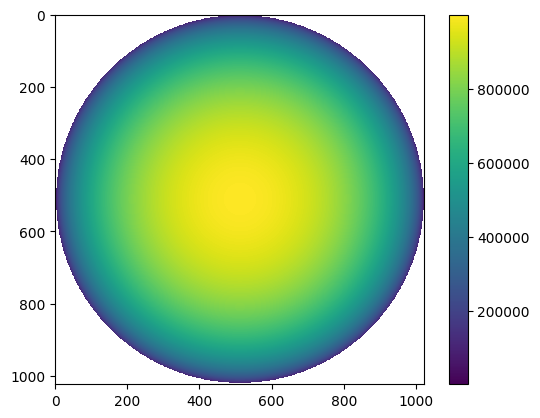

In [20]:
print(antenna_positions.shape)
print(grid_positions.shape)
import matplotlib.pyplot as plt

plt.imshow(grid_positions[:, :, 2])
plt.colorbar()

In [18]:
_visibilities_averger = """
extern "C" __global__

void visibilities_averager(float *distances, float *phases, float *amplitudes, float *out, size_t na, size_t nx, size_t ny){
    int xi = blockIdx.x * blockDim.x + threadIdx.x;
    int yi = blockIdx.y * blockDim.y + threadIdx.y;
    
    volatile float sum = 0;
    int count = 0;
    
    if (xi<nx && yi<ny){
    for (int j=0; j<na; j++){
        for(int k=0; k<j+1; k++){
            
            float _valid = j!=k;
            const float d_phase = distances[(j * nx * ny) + (yi * nx) + xi] - distances[(k * nx * ny) + (yi * nx) + xi];
            sum = sum + _valid * amplitudes[count] * cos(d_phase+ phases[count]);            
            count ++;
        }
    }
        
    }
    out[yi * ny + xi] = 2 * sum/ na / (na+1);
    
}
"""

_nif_imager = """
#include <math_constants.h>

#define SQ(A) (A)*(A)
#define D 3

extern "C" __device__ float distance(float *a, float *b){ return sqrtf(SQ(a[0] - b[0]) + SQ(a[1] - b[1]) + SQ(a[2] -b[2])); }
extern "C" __global__ void nif_imager(float *grid_positions, float *antenna_positions, float frequency, float *phases, float *amplitudes, float *out, size_t na, size_t nx, size_t ny){

    short mBx = (nx / (gridDim.x * blockDim.x)) + (nx % (gridDim.x * blockDim.x)? 1:0);
    short mBy = (ny / (gridDim.y * blockDim.y)) + (ny % (gridDim.y * blockDim.y)? 1:0);
    const float SPEED_OF_LIGHT = 299792458.0;
    const float a =  2 * CUDART_PI_F * frequency / SPEED_OF_LIGHT;
    
    for(short i=0; i<mBx; i++){
    for(short j=0; j<mBy; j++){
        int xi = (i*gridDim.x * blockDim.x) + blockIdx.x * blockDim.x + threadIdx.x;
        int yi = (j*gridDim.y * blockDim.y) + blockIdx.y * blockDim.y + threadIdx.y;
        volatile float sum = 0;
        
        int count = 0;
        if (xi<nx && yi<ny){
            for (int s=0; s<na; s++){
                for(int k=0; k<s+1; k++){
                    volatile float _valid =  s!=k;
                    const float distance_s = a * distance(antenna_positions + s * 3, grid_positions + (xi * ny * D) + (yi * D));
                    const float distance_k = a * distance(antenna_positions + k * 3, grid_positions + (xi * ny * D) + (yi * D));;
                    
                    const float d_phase = distance_s - distance_k;
                    sum += _valid * amplitudes[count] * cos(d_phase+ phases[count]);            
                    count ++;
                }
            }
            
        }
        out[yi * nx + xi] = 2 * sum/ na / (na+1);
    }
    }
    
    
}

"""

mod = SourceModule(_nif_imager)
func = mod.get_function("nif_imager")

    
NUM_THREADS = 32
NUM_BLOCKS = 32
print(NUM_THREADS, NUM_BLOCKS)
print(dir(func))
func(grid_positions_gpu, antenna_positions_gpu, np.array(frequencies.mean(), dtype=np.float32), phases_gpu, amplitudes_gpu, out_gpu, np.array(na, dtype=int), np.array(nx, dtype=int), np.array(ny, dtype=int), block=(NUM_THREADS,NUM_THREADS, 1), grid=(NUM_BLOCKS, NUM_BLOCKS))#, grid=(NUM_BLOCKS, NUM_BLOCKS))
  

32 32
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_launch', '_launch_grid', '_launch_grid_async', '_launch_kernel', '_param_set_size', '_param_setf', '_param_seti', '_param_setv', '_set_block_shape', '_set_shared_size', 'get_attribute', 'param_set_texref', 'prepare', 'prepared_async_call', 'prepared_call', 'prepared_timed_call', 'set_attribute', 'set_cache_config']


CPU times: user 4.35 s, sys: 2.02 ms, total: 4.35 s
Wall time: 4.35 s


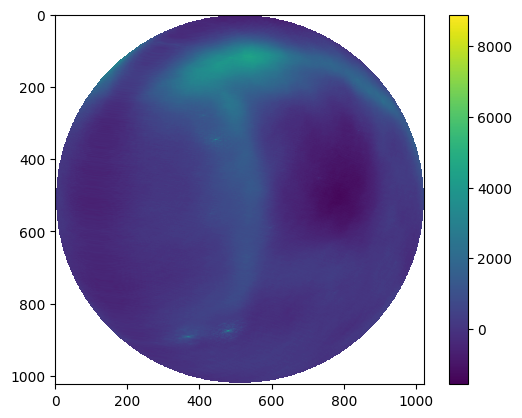

In [19]:
%time cuda.memcpy_dtoh(out, out_gpu)

import matplotlib.pyplot as plt 
plt.imshow(out)
plt.colorbar()


In [14]:

npix_x=50
npix_y=50
import numexpr as ne
freq=frequencies.mean()
vis = visibilitiesI.flatten()[:,np.newaxis]
baseline_indices = np.tril_indices(nantenna)
img = np.real(2* nearfield_imager(vis,np.array(baseline_indices).T, [freq], npix_x, npix_y, station_pqr, radius=radius))

NameError: name 'station_pqr' is not defined

In [ ]:
plt.imshow(img)
plt.colorbar()